In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from skimage.color import rgb2lab, lab2rgb, rgb2gray

In [2]:
# transform to load images in LAB format
LAB_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.permute(1,2,0)),
    transforms.Lambda(rgb2lab),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x[1:3,:,:]/128))
        ])

gray_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.permute(1,2,0)),
    transforms.Lambda(rgb2gray),
    transforms.ToTensor()])

In [4]:
train_input = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=gray_transform)
train_output = torchvision.datasets.CIFAR10(root='./data', train=True,download=False, transform=LAB_transform)
test_input = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=gray_transform)

100%|██████████| 170M/170M [00:05<00:00, 30.4MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In train dataset (without normalization) we have

(L_min,L_max), (a_min, a_max), (b_min, b_max) = ((0.0, 100.0), (-86.183014, 98.23307), (-107.8573, 94.478134)). So we need to normalize a and b.

a_mean, b_mean, a_std, b_std = (0.39576705794991573,5.7253268890978415,10.151768810843748,16.080949185536173)

Normalizing this way is a bit weird, since I suspect that the distribution of a and b is not normal like.


In [5]:
def ab_mean_std(train_output):
    a_sum, a_sq_sum, b_sum, b_sq_sum = 0,0,0,0
    for train in train_output:
        a, b = train[0][:,:,1], train[0][:,:,2]
        a_sum += np.sum(a)
        b_sum += np.sum(b)
        a_sq_sum += np.sum(a**2)
        b_sq_sum += np.sum(b**2)

    pixel_count = len(train_output)*train_output[0][0].shape[0]*train_output[0][0].shape[1]
    a_mean = a_sum /pixel_count
    b_mean = b_sum /pixel_count

    a_std = np.sqrt(a_sq_sum/pixel_count- a_mean**2)
    b_std = np.sqrt(b_sq_sum/pixel_count - b_mean**2)
    return a_mean, a_std, b_mean, b_std


# Building U-Net

In [6]:
import torch.nn as nn
import torch
import torch.nn.functional as F

In [7]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class UNet(nn.Module):

    def __init__(self,depth=2, starting_width=64): # depth is the number of times you go down in the UNet
        super().__init__()
        self.conv = DoubleConv(1, starting_width)
        self.depth = depth
        self.down_list = nn.ModuleList([Down(starting_width*2**i, starting_width*2**(i+1)) for i in range(depth)])
        self.up_list = nn.ModuleList([Up(starting_width*2**i,starting_width*2**(i-1)) for i in range(depth, 0,-1)])
        self.final_conv = nn.Conv2d(starting_width, 2, kernel_size=1)

    def forward(self, x):
        x_arr = [self.conv(x)]

        for down in self.down_list:
            x_arr.append(down(x_arr[-1]))
        y_arr = [self.up_list[0](x_arr[-1],x_arr[-2])]


        for i,up in enumerate(self.up_list[1:]):
            y_arr.append( up(y_arr[-1], x_arr[-i-3]) )

        out = self.final_conv(y_arr[-1])
        return out

In [54]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
old_model = UNet(depth=1).to(device)

In [55]:
device

device(type='cuda')

In [56]:
out = old_model(torch.rand(50,1,32,32).to(device))
out.shape

torch.Size([50, 2, 32, 32])

## Data loader and training

In [11]:
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm, trange

In [12]:
model = UNet(depth=1, starting_width=8).to(device)
sum(p.numel() for p in model.parameters() if p.requires_grad)

6562

In [27]:
class CustomDataset(Dataset):
    def __init__(self, input_data, target_data, transform=None):
        self.input_data = input_data
        self.target_data = target_data
        #self.transform = transform

    def __len__(self):
        return len(self.input_data)

    def __getitem__(self, idx):
        input_image = self.input_data[idx][0]
        target_image = self.target_data[idx][0]

        #if self.transform:
        #    input_image = self.transform(input_image)
        #    target_image = self.transform(target_image)

        return input_image, target_image

# Hyperparameters
batch_size = 1000
learning_rate = 0.001
weight_decay = 0.01  # AdamW weight decay parameter
num_epochs = 10

In [28]:
ex = train_input[0][0]
ex = np.expand_dims(ex,0)
ex.shape

(1, 1, 32, 32)

In [29]:
dataset = CustomDataset(train_input, train_output)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True,pin_memory=True)
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [30]:
from torchsummary import summary
summary(model, (1, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]              80
              ReLU-2            [-1, 8, 32, 32]               0
       BatchNorm2d-3            [-1, 8, 32, 32]              16
            Conv2d-4            [-1, 8, 32, 32]             584
              ReLU-5            [-1, 8, 32, 32]               0
       BatchNorm2d-6            [-1, 8, 32, 32]              16
        DoubleConv-7            [-1, 8, 32, 32]               0
         MaxPool2d-8            [-1, 8, 16, 16]               0
            Conv2d-9           [-1, 16, 16, 16]           1,168
             ReLU-10           [-1, 16, 16, 16]               0
      BatchNorm2d-11           [-1, 16, 16, 16]              32
           Conv2d-12           [-1, 16, 16, 16]           2,320
             ReLU-13           [-1, 16, 16, 16]               0
      BatchNorm2d-14           [-1, 16,

In [31]:
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
from IPython.display import clear_output


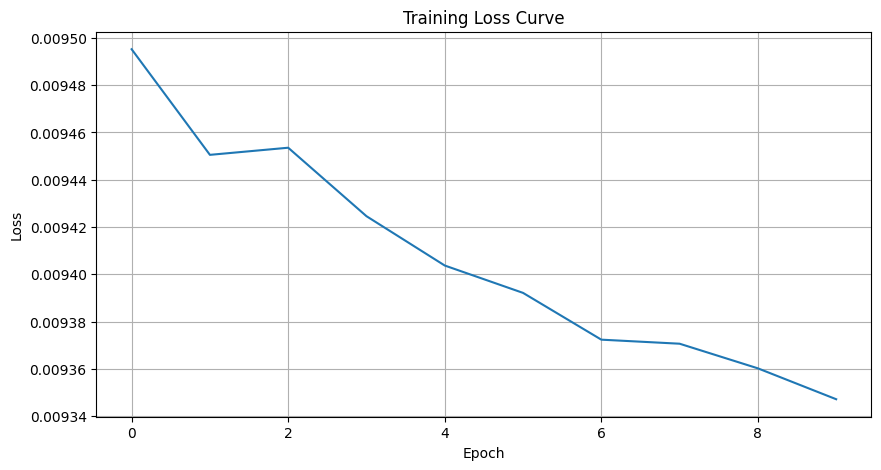

Training completed!


In [32]:
# Function to plot the loss curve
def plot_loss_curve(losses):
    clear_output(wait=True)
    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.title('Training Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

# Initialize list to store losses
losses = []

for epoch in trange(num_epochs, desc="Epochs"):
    model.train()
    batch_loss = 0.0

    # tqdm wrapper for dataloader
    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", position =0, leave=False)

    for inputs, targets in pbar:
        inputs, targets = inputs.to(device), targets.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        batch_loss += loss.item() * inputs.size(0)

        # Update progress bar
        #pbar.set_postfix({"batch_loss": f"{loss.item():.4f}"})

    epoch_loss = batch_loss / len(dataset)
    losses.append(epoch_loss)

    # Print epoch loss
    #tqdm.write(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    if (epoch + 1) % 25 == 0 or epoch == num_epochs - 1:
        plot_loss_curve(losses)

# Save the trained model
torch.save(model.state_dict(), "unet_model_b_"+str(batch_size)+"_ep_"+str(num_epochs))

# Final loss curve plot
plot_loss_curve(losses)

print("Training completed!")

In [39]:
# Not sure why training is so slow. Should play around more with dataloader.
# Maybe it's because I'm keeping the label and only throwing it away when I'm doing getitem
# Loss only going down a bit makes sense. I'm working with a very small model (only ~6000 parameters)

In [123]:
def run_inference_rgb(model, input_tensor):
    input = input_tensor[0].to(device).unsqueeze(0)
    with torch.no_grad():  # No need to track gradients during inference
        output = (model(input).squeeze(0)*128).permute(1,2,0).to('cpu') # unnormalize
    l = np.expand_dims(rgb2lab(input_tensor[0].repeat(3,1,1).permute(1,2,0))[:,:,0], 2)
    print(l.shape, output.shape)
    lab = np.concatenate((l,output), axis=2)
    rgb = lab2rgb(lab)
    return rgb

In [130]:
input_ex = train_input[3]

In [131]:
im = run_inference_rgb(model, input_ex)

(32, 32, 1) torch.Size([32, 32, 2])


In [132]:
(input_ex[0].to(device).unsqueeze(0)).shape

torch.Size([1, 1, 32, 32])

In [135]:
input_ex[0].shape

torch.Size([1, 32, 32])

In [136]:
def display(tensor):
    return transforms.functional.to_pil_image(tensor)

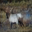

In [137]:
display(im)